In [1]:
%reset -f
import pandas as pd
import tensorflow.keras
import pickle, sys, warnings

sys.path.append('/home/d/dlr10/Documents/02_Statitics_modelling/0_FunctionsScripts')
import Loading_Data_Functions as load_fn
import FineTuning_Functions as FineTuning
import Learning_Curves_Functions as LearningCurves

from tensorflow.keras.models import load_model
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.fontset'] = 'cm'

2023-10-28 02:47:29.976378: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-28 02:47:29.976412: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# ============================================================================
##############################################################################
##############################################################################
# IMPORT ALL TIME PACKAGES
##############################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle, time, random, sys, warnings
# sys.path is a list of absolute path strings
sys.path.append('/home/d/dlr10/Documents/02_Statitics_modelling/0_FunctionsScripts')
import Loading_Data_Functions as load_fn
import FineTuning_Functions as FineTuning
import Learning_Curves_Functions as LearningCurves
##############################################################################
# IMPORT DEEP LEARNING PACKAGES
##############################################################################

from sklearn.model_selection import cross_val_score, StratifiedKFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten, LeakyReLU
from tensorflow.keras import layers

from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import make_scorer, accuracy_score
LeakyReLU = LeakyReLU(alpha=0.1)

from bayes_opt import BayesianOptimization


pd.set_option("display.max_columns", None)


# ENCODING FUNCTIONS
##############################################################################

# ENCODING CATEGORICAL VARIABLES WITH TARGET ENCODER OR NORMALISE CONTINUOUS VARIABLES
# https://towardsdatascience.com/target-encoding-and-bayesian-target-encoding-5c6a6c58ae8c
def target_encoder_Binary(column, target, X_data):
    df = []
    for cat in X_data[column].unique():
        row = []
        row.append(len(X_data[(X_data[target]==0) & (X_data[column] == cat)]))
        row.append(len(X_data[(X_data[target]==1) & (X_data[column] == cat)]))
        df.append(row)
    df = pd.DataFrame(df, index = X_data[column].unique(), columns = ['0','1'])
    df['prob'] = df['1']/(df['1']+df['0'])
    col_encod = X_data[column].map(dict(zip(df.index, df['prob'])))
    return col_encod, df
############################################################
def Normalise_n_encode_train_set(X_data, feat_list, data_types):
    encoder = []
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        if data_types[feat] == 'Continuous':
            X_data_feat = X_data[feat]
            mean        = X_data_feat.mean()
            std         = X_data_feat.std()
            X_data_norm_2[feat] = (X_data_feat - mean)/std
            encoder.append([feat, data_types[feat], [mean, std]])
        elif data_types[feat] == 'Categorical':
            X_data_norm_2[feat],df = target_encoder_Binary(feat, 'Mortality', X_data)
            encoder.append([feat, data_types[feat], df])
        elif data_types[feat] == 'Binary':
            X_data_norm_2[feat] = X_data[feat].copy()
            encoder.append([feat, data_types[feat], ""])
    encoder =pd.DataFrame(encoder, columns = ['feature','type','parameters'])
    return X_data_norm_2,encoder
############################################################
def Normalise_n_encode_val_set(val_data, norm_encoder, feat_list, data_types):
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        if data_types[feat] == 'Continuous':
            X_data_feat = val_data[feat]
            mean, std   = norm_encoder[norm_encoder['feature'] == feat].iloc[0]['parameters']
            X_data_norm_2[feat] = (X_data_feat - mean)/std

        elif data_types[feat] == 'Categorical':
            df = norm_encoder[norm_encoder['feature'] == feat].iloc[0]['parameters']
            X_data_norm_2[feat] = val_data[feat].map(dict(zip(df.index, df['prob'])))
            X_data_norm_2[feat] = X_data_norm_2[feat].fillna(0)
        elif data_types[feat] == 'Binary':
            X_data_norm_2[feat] = val_data[feat].copy()
    return X_data_norm_2
##############################################################################
# PLOTTING FUNCTIONS 
##############################################################################
def history_plots_(history, SAVE = 0, name = ''):
    auc_keys = [x for x in history.history.keys() if 'auc' in x]
    loss = history.history["loss"];     val_loss = history.history["val_loss"]
    acc  = history.history["accuracy"]; val_acc  = history.history["val_accuracy"]
    auc  = history.history[auc_keys[0]];      val_auc = history.history[auc_keys[1]]
    epochs  = range(1, len(acc) + 1)
    f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (8,4))
    ax0.plot(epochs, loss, "bo", label="Training Loss")
    ax0.plot(epochs, val_loss, "b", label="Validation Loss")
    ax0.set_title("Train-val Loss")
    ax1.plot(epochs, acc, "bo", label="Training Accuracy")
    ax1.plot(epochs, val_acc, "b", label="Validation Accuracy")
    ax1.set_title("Train-val Accuracy")
    ax2.plot(epochs, auc, "bo", label="Training AUC")
    ax2.plot(epochs, val_auc, "b", label="Validation AUC")
    ax2.set_title("Train-val AUC")
    plt.legend()
    if SAVE == 1: plt.savefig(name, transparent = True, bbox_inches = "tight")
    plt.show()
# ============================================================================

t_tot = time.time()
# ##############
# 1. LOAD DATA ---------------------------------------------------------------
# ============================================================================
t = time.time()
path = r'/home/d/dlr10/Documents/02_Statitics_modelling/DataSets/'
df_patients_16_18, df_admissions_16_18, df_eobs_16_18 = load_fn.Load_data()
df_patients_19_20, df_admissions_19_20, df_eobs_19_20 = load_fn.Load_data('2019_2020')

X_data_16_18 = pickle.load(open(path + 'df_ts_2016_18.pickle','rb')).drop(columns = 'no_sample_series')
X_data_19_20 = pickle.load(open(path + 'df_ts_2019_20.pickle','rb')).drop(columns = 'no_sample_series')


# Dictionary of features and types --------
data_types = pd.read_csv('/home/d/dlr10/Documents/02_Statitics_modelling/2_Statistics/csv_Type_variables.csv')
data_types = data_types.set_index('Variable').to_dict()['Type']

# List of features ------------------------
feat_list = X_data_16_18.columns.tolist()
feat_list = feat_list[1:-1]

# Resulst vaiables ------------------------
df_results_train = pd.DataFrame()
df_results_valid = pd.DataFrame()
dict_fpr_tpr = {}

print("Elapsed time loading data:", time.time()-t)


# ##############
# 2. PROCESSING DATA ---------------------------------------------------------
# ============================================================================
t = time.time()
### BALANCED DATA ####################################
random.seed(2)
X_0 = X_data_16_18[X_data_16_18['Mortality'] == 0]['admission_id'].unique().tolist()
X_1 = X_data_16_18[X_data_16_18['Mortality'] == 1]

list_X_0   = random.sample(range(len(X_0)),len(X_1['admission_id'].unique().tolist()))
X_0_2_adms = [X_0[pos] for pos in list_X_0]
X_0_2      = X_data_16_18[X_data_16_18['admission_id'].isin(X_0_2_adms)]

X_data_bal = pd.concat([X_1,X_0_2])

### SPLIT DATA #######################################
train_set = X_data_bal.copy()
valid_set = X_data_19_20.copy()

### ENCODING DATA ####################################
train_set_norm, encoder = Normalise_n_encode_train_set(train_set, feat_list, data_types)
valid_set_norm          = Normalise_n_encode_val_set(valid_set, encoder, feat_list, data_types)

### SET DATA AS ARRAYs ###############################
num_samp_train = len(train_set['admission_id'].unique().tolist())
num_samp_valid = len(valid_set['admission_id'].unique().tolist())
num_features   = len(train_set_norm.columns.tolist())
num_time_samp  = 144
X_train    = np.array(train_set_norm).reshape((num_samp_train, num_time_samp, num_features ))
X_valid    = np.array(valid_set_norm).reshape((num_samp_valid, num_time_samp, num_features ))
df         = train_set[['admission_id', 'Mortality']].groupby(by= 'admission_id').mean()
mort_dict  = dict(zip(df.index.tolist(),df['Mortality']))
y_train    = np.array([mort_dict[adm] for adm in train_set['admission_id'].unique().tolist()])

df         = valid_set[['admission_id', 'Mortality']].groupby(by= 'admission_id').mean()
mort_dict  = dict(zip(df.index.tolist(),df['Mortality']))
y_valid   = np.array([mort_dict[adm] for adm in valid_set['admission_id'].unique().tolist()])
print("Elapsed time processing data:", time.time()-t)
# ============================================================================

Elapsed time loading data: 35.72729277610779
Elapsed time processing data: 10.318792581558228


_________________________

_________________________

_________________________

In [3]:
final_df = pd.DataFrame()
lst_fpr_tpr = []

# GRU

In [4]:
X_valid.shape
X_valid = X_valid.astype(float)

2023-10-28 02:48:23.297372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-10-28 02:48:23.297412: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-28 02:48:23.297440: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alice-login02): /proc/driver/nvidia/version does not exist
2023-10-28 02:48:23.298009: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-28 02:48:25.857755: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR 

Confidence interval for the score: [0.745 - 0.765]


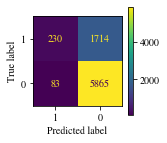

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC,name
0,0.734824,0.118313,0.20381,0.772301,0.754584,0.168608,"[0.75, 0.765]",Unbal_GRU


time elapsed 28.823832511901855


In [5]:
path      = r'/home/d/dlr10/Documents/02_Statitics_modelling/4_Modelling_TS/04_GRU_NN'
file_name = r'/Unbalanced_GRU_NN_history.pickle'
params_nn_, history= pickle.load(open(path + file_name,'rb'))
clf_model = load_model(path + '/Unbalanced_GRU_NN.h5')

y_test_proba    = clf_model.predict(X_valid)
y_test_predict  = FineTuning.adjusted_classes(y_test_proba, 0.5)

df_results_valid, fpr_tpr = LearningCurves.results_precision_recall_cm(y_valid, y_test_predict, y_test_proba,fig_size = None)
lst_fpr_tpr.append(fpr_tpr)

#plt.savefig(name +'_valid_cm.png', transparent = True, bbox_inches = "tight")
plt.show()
df_results_valid['name'] = 'Unbal_GRU'
display(df_results_valid)
final_df = pd.concat([final_df,df_results_valid])
print('time elapsed', time.time() - t)

Confidence interval for the score: [0.755 - 0.775]


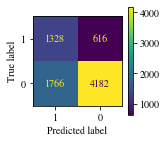

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC,name
0,0.429218,0.683128,0.527193,0.698175,0.764705,0.182621,"[0.76, 0.775]",Bal_GRU


time elapsed 14.265460968017578


In [6]:
t = time.time()

model_name     = r'/Balanced_GRU_NN_ERC_original'
path           = r'/home/d/dlr10/Documents/02_Statitics_modelling/4_Modelling_TS/04_GRU_NN/GRU_ERC'
file_name      = model_name + '_history.pickle'

params_nn_, history= pickle.load(open(path + file_name,'rb'))
clf_model = load_model(path + model_name +'.h5')

y_test_proba    = clf_model.predict(X_valid)
y_test_predict  = FineTuning.adjusted_classes(y_test_proba, 0.45)

df_results_valid, fpr_tpr = LearningCurves.results_precision_recall_cm(y_valid, y_test_predict, y_test_proba,fig_size = None)
lst_fpr_tpr.append(fpr_tpr)
#plt.savefig(name +'_valid_cm.png', transparent = True, bbox_inches = "tight")
df_results_valid['name'] = 'Bal_GRU'
plt.show()
display(df_results_valid)
final_df = pd.concat([final_df,df_results_valid])

print('time elapsed', time.time() - t)

# LSTM

Confidence interval for the score: [0.744 - 0.765]


,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC,name
0,0.66443,0.152778,0.248432,0.772301,0.754325,0.164022,"[0.74, 0.765]",Unbal_LSTM


time elapsed 24.58651065826416


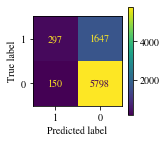

In [7]:
path      = r'/home/d/dlr10/Documents/02_Statitics_modelling/4_Modelling_TS/03_LSTM_RNN'
file_name = r'/Unbalanced_LSTM_NN_history.pickle'
params_nn_, history= pickle.load(open(path + file_name,'rb'))
clf_model = load_model(path + '/Unbalanced_LSTM_NN.h5')

y_test_proba    = clf_model.predict(X_valid)
y_test_predict  = FineTuning.adjusted_classes(y_test_proba, 0.5)

df_results_valid, fpr_tpr = LearningCurves.results_precision_recall_cm(y_valid, y_test_predict, y_test_proba,fig_size = None)
lst_fpr_tpr.append(fpr_tpr)
#plt.show()
df_results_valid['name'] = 'Unbal_LSTM'
display(df_results_valid)
final_df = pd.concat([final_df,df_results_valid])
print('time elapsed', time.time() - t)

Confidence interval for the score: [0.731 - 0.752]


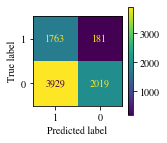

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC,name
0,0.309733,0.906893,0.46176,0.479219,0.741048,0.283645,"[0.73, 0.752]",Bal_LSTM


time elapsed 19.14432406425476


In [8]:
t = time.time()

model_name = r'/Balanced_LSTM_NN_original'
path       = r'/home/d/dlr10/Documents/02_Statitics_modelling/4_Modelling_TS/03_LSTM_RNN/LSTM_ERC'
file_name  = model_name + '_history.pickle'

params_nn_, history= pickle.load(open(path + file_name,'rb'))
clf_model = load_model(path + model_name +'.h5')

y_test_proba    = clf_model.predict(X_valid)
y_test_predict  = FineTuning.adjusted_classes(y_test_proba, 0.45)

df_results_valid, fpr_tpr = LearningCurves.results_precision_recall_cm(y_valid, y_test_predict, y_test_proba,fig_size = None)
lst_fpr_tpr.append(fpr_tpr)
#plt.savefig(name +'_valid_cm.png', transparent = True, bbox_inches = "tight")
df_results_valid['name'] = 'Bal_LSTM'
plt.show()
display(df_results_valid)
final_df = pd.concat([final_df,df_results_valid])

print('time elapsed', time.time() - t)

# Plot AUROC Curves

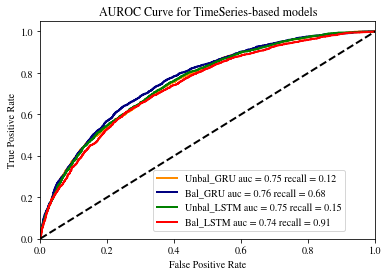

In [9]:
#########################################################################################
# Function to extract and put results together
#########################################################################################

labels = final_df['name'].tolist()
for idx, fpr_tpr in enumerate(lst_fpr_tpr):
    colors = ['darkorange', 'navy','g','r','c', 'm']
    fpr = fpr_tpr[0]; tpr = fpr_tpr[1]; row = final_df.iloc[idx]
    clf_name = row['name']; clf_auc  = row['AUC']; clf_rcll = row['Recall']
    lw = 2    
    label = clf_name + " auc = {:,.2f} recall = {:,.2f}".format(clf_auc, clf_rcll)
    plt.plot(fpr,  tpr,  color=colors[idx],  lw=lw,label= label)

plt.plot([0, 1], [0, 1], color="k", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUROC Curve for TimeSeries-based models")

plt.legend(bbox_to_anchor=(0.32, 0.34))
plt.savefig('AUROC_TimeSeries_models.png', transparent = True, bbox_inches = "tight")
plt.show()

In [10]:
idx

3

In [11]:
final_df

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC,name
0,0.734824,0.118313,0.203810,0.772301,0.754584,0.168608,"[0.75, 0.765]",Unbal_GRU
0,0.429218,0.683128,0.527193,0.698175,0.764705,0.182621,"[0.76, 0.775]",Bal_GRU
0,0.664430,0.152778,0.248432,0.772301,0.754325,0.164022,"[0.74, 0.765]",Unbal_LSTM
0,0.309733,0.906893,0.461760,0.479219,0.741048,0.283645,"[0.73, 0.752]",Bal_LSTM


# Store results in pickle

In [12]:
pickle.dump(final_df, open('ts_mortality_results.pickle', 'wb'))
final_df

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC,name
0,0.734824,0.118313,0.203810,0.772301,0.754584,0.168608,"[0.75, 0.765]",Unbal_GRU
0,0.429218,0.683128,0.527193,0.698175,0.764705,0.182621,"[0.76, 0.775]",Bal_GRU
0,0.664430,0.152778,0.248432,0.772301,0.754325,0.164022,"[0.74, 0.765]",Unbal_LSTM
0,0.309733,0.906893,0.461760,0.479219,0.741048,0.283645,"[0.73, 0.752]",Bal_LSTM
